##Part 1: Import MNist Data Set


x_train shape: (60000, 28, 28)
Number of images in x_train 60000
Number of images in x_test 10000


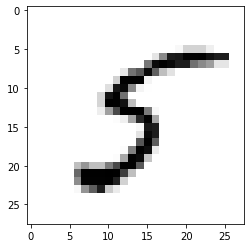

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense, Flatten, BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt
import pandas as pd

#Importing the mnist data set
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
img_rows, img_cols, channels = 28, 28, 1

print('x_train shape:', x_train.shape)
print('Number of images in x_train', x_train.shape[0])
print('Number of images in x_test', x_test.shape[0])

image_index = 543 # You may select anything up to 60,000
#print(x_train[image_index]) # The label is 8
plt.imshow(x_train[image_index], cmap='Greys')


##Part 2: Normalise MNIST dataset

In [0]:
# #Reshaping the array to 4-dims so that it can work with the Keras API
# x_train = x_train.reshape(-1, 28, 28, 1)
# x_test = x_test.reshape(-1, 28, 28, 1)
# input_shape = (28, 28, 1)
# # Making sure that the values are float so that we can get decimal points after division
# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')
# # Normalizing the RGB codes by dividing it to the max RGB value.
# x_train /= 255
# x_test /= 255
# print('x_train shape:', x_train.shape)
# print('Number of images in x_train', x_train.shape[0])
# print('Number of images in x_test', x_test.shape[0])

x_train = (x_train.astype(np.float32) - 127.5) / 127.5
img_rows, img_cols, channels = 28, 28, 1


#print sample to check normalization
#print(x_train[123])

##Part 3: Build Generator


In [0]:
def build_generator(noise_dim, Rows, Cols, Channels):
    generator = Sequential()
    
    generator.add(Dense(256, input_dim=noise_dim))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(img_rows*img_cols*channels, activation='tanh'))
    
    generator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
    return generator

##Part 4: Build Discriminator

In [0]:
def build_discriminator(Rows, Cols, Channels):
  discriminator = Sequential()
    
  discriminator.add(Dense(1024, input_dim=Rows*Cols*Channels))
  discriminator.add(LeakyReLU(0.2))

  discriminator.add(Dense(512))
  discriminator.add(LeakyReLU(0.2))

  discriminator.add(Dense(256))
  discriminator.add(LeakyReLU(0.2))
  
  discriminator.add(Dense(1, activation='sigmoid'))
  
  discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
  return discriminator



##Part 5: Build GAN

In [15]:
generator= build_generator(100,img_rows,img_cols,channels)
discriminator= build_discriminator( img_rows, img_cols, channels)
discriminator.trainable = False

#Create a random noise image of dimension 100
gan_input = Input(shape=(100,))

fake_image= generator(gan_input)
print(fake_image.shape)

#Feed fake image to discriminator 
gan_output = discriminator(fake_image)

#Optimizer 
#optimizer = 

#Create GAN
gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
gan.summary()

#Let's see how the initial random seed image looks. 
#print(fake_image)


#plt.imshow(fake_image.eval(session=tf.compat.v1.Session()), cmap='Greys')

(None, 784)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 784)               1486352   
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


##Part 6: Train our GAN

Epoch number: 0 	 Discriminator Loss: 0.4659560024738312 		 Generator Loss: 2.2835278511047363
Epoch number: 1 	 Discriminator Loss: 0.5961600542068481 		 Generator Loss: 1.2766621112823486
Epoch number: 2 	 Discriminator Loss: 0.5315303802490234 		 Generator Loss: 1.7207863330841064
Epoch number: 3 	 Discriminator Loss: 0.5188078284263611 		 Generator Loss: 1.4329416751861572
Epoch number: 4 	 Discriminator Loss: 0.5143842101097107 		 Generator Loss: 1.6631606817245483
Epoch number: 5 	 Discriminator Loss: 0.5694709420204163 		 Generator Loss: 1.3918476104736328
Epoch number: 6 	 Discriminator Loss: 0.5612757802009583 		 Generator Loss: 1.526207447052002
Epoch number: 7 	 Discriminator Loss: 0.6400319337844849 		 Generator Loss: 1.5898160934448242
Epoch number: 8 	 Discriminator Loss: 0.49775612354278564 		 Generator Loss: 1.5689120292663574
Epoch number: 9 	 Discriminator Loss: 0.6071740388870239 		 Generator Loss: 1.5336272716522217
Epoch number: 10 	 Discriminator Loss: 0.541381478

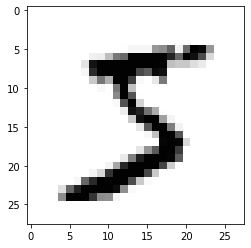

In [17]:
#We train our GAN for 35 epochs. 

batch_size = 16
steps_per_epoch = 3750 
epochs = 35
noise_dim=100

for epoch in range(epochs):
  for batch in range(steps_per_epoch):
    noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
    fake_x = generator.predict(noise)

    #fake_img=fake_img.reshape((16,28, 28))
    #plt.imshow(fake_x, cmap='Greys')
    real_x = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]
        
    #plt.imshow(x_train[0], cmap='Greys')

    fake_x=fake_x.reshape(batch_size,img_rows,img_cols)

    x = np.concatenate((real_x, fake_x))
    x=x.reshape(32, 784)

    #print(x.shape)

    disc_y = np.zeros(2*batch_size)
    disc_y[:batch_size] = 0.9

    d_loss = discriminator.train_on_batch(x, disc_y)

    y_gen = np.ones(batch_size)
    g_loss = gan.train_on_batch(noise, y_gen)
  print(f'Epoch number: {epoch} \t Discriminator Loss: {d_loss} \t Generator Loss: {g_loss}')


##Part 7: Display Images

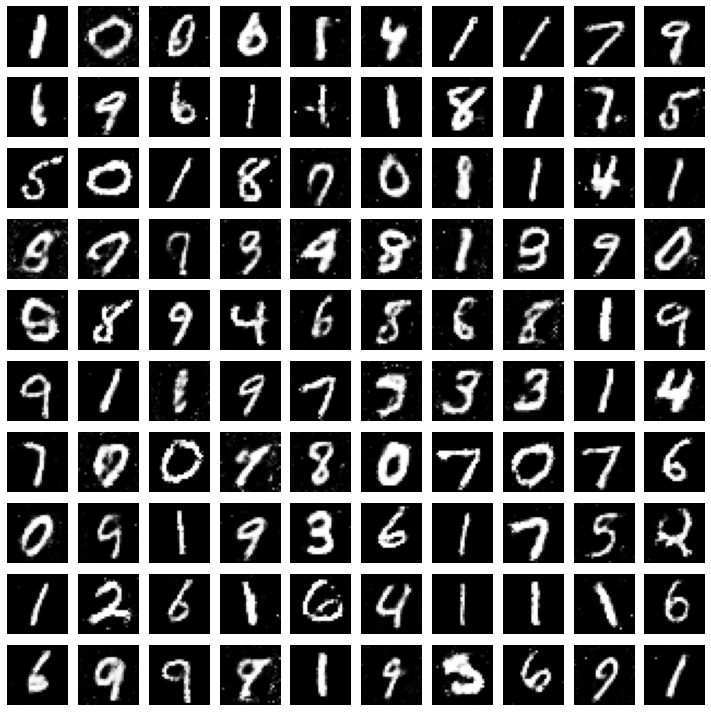

In [18]:
def show_images(noise):
    generated_images = generator.predict(noise)
    plt.figure(figsize=(10, 10))
    
    for i, image in enumerate(generated_images):
        plt.subplot(10, 10, i+1)
        if channels == 1:
            plt.imshow(image.reshape((img_rows, img_cols)), cmap='gray')
        else:
            plt.imshow(image.reshape((img_rows, img_cols, channels)))
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

noise = np.random.normal(0, 1, size=(100, noise_dim))
show_images(noise)